In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
# from doqu import models_ddos
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler


2024-05-05 02:34:44.979282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 02:34:45.790049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_24277/3230676359.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# ! pip install keras_tuner

In [4]:
filename='pcap_data.csv'    

trainfile = pd.read_csv(filename)
label = trainfile['target']
data = pd.DataFrame(trainfile).to_numpy()

# Data Pre-Processing

In [5]:
# Standardisation

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [6]:
# Test data 20%
train_data, test_data, train_label, test_label = \
    train_test_split(scaled_data, label, test_size=0.20, stratify=label)
    
# Train 70%, Validation%10
train_data, val_data, train_label, val_label = \
    train_test_split(train_data, train_label,test_size=0.125, stratify=train_label)

In [7]:
# One hot encoding of labels

# One-hot encode the labels
train_label = to_categorical(train_label,3)
val_label = to_categorical(val_label,3)
test_label = to_categorical(test_label,3)


# Defining Callbacks

In [12]:
# CALLBACKS 
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=0,
                              mode='min')

modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_accuracy:.4f}.keras',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max')

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.1,
                                  patience=7,
                                  verbose=1,
                                  epsilon=1e-4,
                                  mode='min')

# Build Model

In [16]:
# Defining Parameters

inshape = train_data.shape[1]
lr = 1e-4
N = 64
epochs = 50
nclass = 3 # np.unique(train_label).shape[0]

In [14]:
# Define your neural network architecture
def create_model(lr, N, inshape):
    model = Sequential()
    model.add(Conv1D(N, kernel_size=3, activation='relu', input_shape=(inshape, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nclass, activation='softmax'))  # Assuming nclass is defined elsewhere
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model(lr=lr, N=N, inshape=inshape)

/home/ec2-user/anaconda3/envs/biostrand/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-05 02:34:51.746201: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# TRAIN MODEL


In [17]:
history = model.fit(train_data,
                    train_label,
                    shuffle=True,
                    epochs=epochs,
                    batch_size=32,  # 256,#128,#32, 64
                    # validation_data=validation_generator,
                    # validation_split=0.2,
                    validation_data=(val_data, val_label),
                    callbacks=[modelCheckPoint, earlyStopping, reduce_lr_loss])
                    # class_weight=class_weights)

Epoch 1/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8213 - loss: 0.5639 - val_accuracy: 1.0000 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 2/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 6.3859e-04 - learning_rate: 0.0010
Epoch 4/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 5.9840e-04 - val_accuracy: 1.0000 - val_loss: 3.1295e-04 - learning_rate: 0.0010
Epoch 5/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 3.0470e-04 - val_accuracy: 1.0000 - val_loss: 1.8235e-04 - learning_rate: 0.0010
Epoch 6/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 1.7579e-04 - val_accuracy: 1.0000 - val_loss: 1.1503e-04 - learning_rate: 0.0010
Epoch 7/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accura

# Load Best Model

In [18]:
str_models = os.listdir('./savemodels')
str_models = np.sort(str_models)
best_model = str_models[str_models.size-1]
print('best_model=', best_model)
model.load_weights('./savemodels/'+best_model)

best_model= model5class.weights.001-1.0000.keras


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,459 (1.13 MB)

 Trainable params: 98,819 (386.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,640 (772.04 KB)

# Predict on Test Data

In [26]:
# Confusion matrix 
print('TEST DATA-Confusion matrix:')  
pred = model.predict(test_data)
pred_y = pred.argmax(axis=-1)
test_label_indices = test_label.argmax(axis=-1)

cm = confusion_matrix(test_label_indices, pred_y)
print(cm)

TEST DATA-Confusion matrix:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
[[1001    0    0]
 [   0  999    4]
 [   0    1  989]]


# Further Visualizations

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.9980 - loss: 0.0202
Test accuracy: 0.9983299970626831


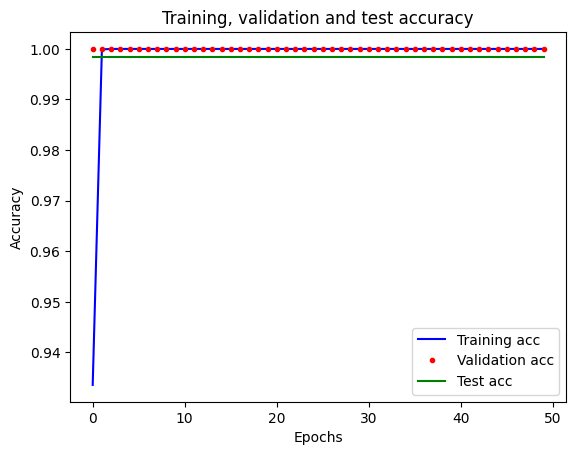

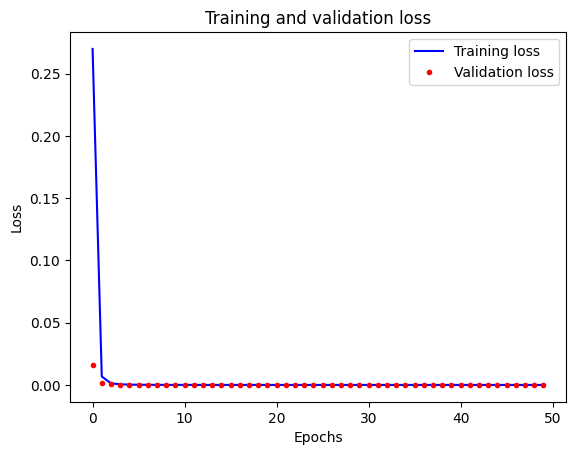

In [30]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data, test_label)

print('Test accuracy:', test_acc)

# Plot training, validation, and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

test_acc_values = [test_acc] * len(acc)

np.save('historydata.npy',[acc,val_acc,loss,val_loss])
[acc, val_acc, loss, val_loss] = np.load('historydata.npy')

plt.figure()
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.plot(epochs, test_acc_values, 'g', label='Test acc')
plt.title('Training, validation and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Comments

"""
Class weighting can be very useful in scenarios where your data is imbalanced, meaning one class has significantly more samples than another.
In such cases, a machine learning model can end up biased towards the class with more samples, as it gets more "experience" with that class
during training.

By applying class weights, you're telling the model to "pay more attention" to under-represented classes. The weights are used to adjust
the loss function during training. Specifically, samples from under-represented classes will contribute more to the total loss. 
As a result, the model is incentivized to correct mistakes on these samples more than on samples from over-represented classes.

In other words, class weighting can help improve the model's performance on under-represented classes, making the model more balanced 
and fair, and improving its overall performance when the data is imbalanced.
"""

'\nClass weighting can be very useful in scenarios where your data is imbalanced, meaning one class has significantly more samples than another.\nIn such cases, a machine learning model can end up biased towards the class with more samples, as it gets more "experience" with that class\nduring training.\n\nBy applying class weights, you\'re telling the model to "pay more attention" to under-represented classes. The weights are used to adjust\nthe loss function during training. Specifically, samples from under-represented classes will contribute more to the total loss. \nAs a result, the model is incentivized to correct mistakes on these samples more than on samples from over-represented classes.\n\nIn other words, class weighting can help improve the model\'s performance on under-represented classes, making the model more balanced \nand fair, and improving its overall performance when the data is imbalanced.\n'